## PRE-PROCESSING

In [1]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mglearn

In [3]:
# importa la tabella di lookup
try:
    pokemon_lookup = pd.read_csv('pokemon.csv', error_bad_lines=False, dtype=str)
except FileNotFoundError:
    pokemon_lookup = pd.read_csv('pokemon.csv.gz', compression='gzip',
                                 error_bad_lines=False, dtype=str)

In [4]:
# leggi i file e salva l'input in due DataFrames
training_data = pd.read_csv('train.csv', error_bad_lines=False, dtype=str)
test_data = pd.read_csv('test.csv', error_bad_lines=False, dtype=str)

In [5]:
# verifica presenza valori nulli nelle colonne del training set
training_data.isnull().any()

Winner            False
First_pokemon     False
Second_pokemon    False
dtype: bool

In [6]:
# verifica presenza valori nulli nelle colonne della tabella di lookup
pokemon_lookup.isnull().any()

#             False
Name           True
Type 1        False
Type 2         True
HP            False
Attack        False
Defense       False
Sp. Atk       False
Sp. Def       False
Speed         False
Generation    False
Legendary     False
dtype: bool

In [7]:
# drop delle colonne inutili ai fini della valutazione dalla tabella di lookup
pokemon_lookup = pokemon_lookup.drop(["Name","Generation","Legendary"], axis=1)
pokemon_lookup

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Grass,Poison,45,49,49,65,65,45
1,2,Grass,Poison,60,62,63,80,80,60
2,3,Grass,Poison,80,82,83,100,100,80
3,4,Grass,Poison,80,100,123,122,120,80
4,5,Fire,NaN,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...
795,796,Rock,Fairy,50,100,150,100,150,50
796,797,Rock,Fairy,50,160,110,160,110,110
797,798,Psychic,Ghost,80,110,60,150,130,70
798,799,Psychic,Dark,80,160,60,170,130,80


In [8]:
# ipotizzando che la colonna del "Type 2" sia rilevante in una battaglia, ho deciso di sostituire i valori
# nulli con una copia del valore contenuto nel corrispondente "Type 1"
for i in pokemon_lookup.get("#"):
    inti = int(i)-1
    if pd.isna(pokemon_lookup.iloc[inti].get("Type 2")):
        pokemon_lookup.at[inti, "Type 2"] = pokemon_lookup.iloc[inti].get("Type 1")

# stampa di verifica corretta sostituzione
pokemon_lookup[:10]

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Grass,Poison,45,49,49,65,65,45
1,2,Grass,Poison,60,62,63,80,80,60
2,3,Grass,Poison,80,82,83,100,100,80
3,4,Grass,Poison,80,100,123,122,120,80
4,5,Fire,Fire,39,52,43,60,50,65
5,6,Fire,Fire,58,64,58,80,65,80
6,7,Fire,Flying,78,84,78,109,85,100
7,8,Fire,Dragon,78,130,111,130,85,100
8,9,Fire,Flying,78,104,78,159,115,100
9,10,Water,Water,44,48,65,50,64,43


In [9]:
# verifica sostituzione completa dei valori nulli
pokemon_lookup.isnull().any()

#          False
Type 1     False
Type 2     False
HP         False
Attack     False
Defense    False
Sp. Atk    False
Sp. Def    False
Speed      False
dtype: bool

In [10]:
# ottenimento valori di tipo
types = pokemon_lookup["Type 1"].values
types_clean = list(dict.fromkeys(types))
print(types_clean)

['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric', 'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice', 'Dragon', 'Dark', 'Steel', 'Flying']


In [11]:
# encoding selettivo delle sole colonne che contengono categorical variables
encoder = LabelEncoder()
encoder.fit(types_clean)

# encoding colonna "Type 1"
encoded = encoder.transform(pokemon_lookup["Type 1"])
for i in pokemon_lookup.get("#"):
    inti = int(i)-1
    pokemon_lookup.at[inti, "Type 1"] = encoded[inti]
    
# encoding colonna "Type 2"
encoded = encoder.transform(pokemon_lookup["Type 2"])
for i in pokemon_lookup.get("#"):
    inti = int(i)-1
    pokemon_lookup.at[inti, "Type 2"] = encoded[inti]

pokemon_lookup

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,9,13,45,49,49,65,65,45
1,2,9,13,60,62,63,80,80,60
2,3,9,13,80,82,83,100,100,80
3,4,9,13,80,100,123,122,120,80
4,5,6,6,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...
795,796,15,4,50,100,150,100,150,50
796,797,15,4,50,160,110,160,110,110
797,798,14,8,80,110,60,150,130,70
798,799,14,1,80,160,60,170,130,80


In [12]:
# join dei dataframes per ottenere un insieme di training adeguato
training_partial = training_data.merge(pokemon_lookup, how='left',
                                   left_on="First_pokemon", right_on="#", suffixes=('', '_first'))

training_def = training_partial.merge(pokemon_lookup, how='left',
                                   left_on="Second_pokemon", right_on="#", suffixes=('', '_2'))

training_def = training_def.drop(["#", "#_2"], axis=1)
training_def

,Winner,First_pokemon,Second_pokemon,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1_2,Type 2_2,HP_2,Attack_2,Defense_2,Sp. Atk_2,Sp. Def_2,Speed_2
0,613,613,698,10,1,60,82,45,45,45,74,0,6,55,85,55,50,55,60
1,20,20,403,0,13,65,150,40,15,80,145,17,17,55,104,105,94,75,52
2,547,119,547,13,13,65,90,120,85,70,60,14,14,120,70,120,75,130,85
3,461,132,461,14,4,40,45,65,100,120,90,0,16,60,69,95,69,95,36
4,16,16,34,0,7,60,45,50,90,80,70,10,10,75,100,110,45,55,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,793,793,621,4,4,126,131,95,131,98,99,1,5,50,75,70,35,70,48
31996,600,217,600,14,14,48,72,48,72,48,48,5,5,75,125,75,30,75,85
31997,23,99,23,17,11,50,95,180,85,45,70,12,7,83,80,75,70,70,101
31998,500,207,500,9,9,30,30,30,30,30,30,10,10,68,72,78,38,42,32


In [13]:
# join dei dataframes per ottenere un insieme di test adeguato
test_partial = test_data.merge(pokemon_lookup, how='left',
                                   left_on="First_pokemon", right_on="#", suffixes=('', '_1'))

test_def = test_partial.merge(pokemon_lookup, how='left',
                                   left_on="Second_pokemon", right_on="#", suffixes=('', '_2'))

test_def = test_def.drop(["#", "#_2"], axis=1)
test_def

,Winner,First_pokemon,Second_pokemon,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1_2,Type 2_2,HP_2,Attack_2,Defense_2,Sp. Atk_2,Sp. Def_2,Speed_2
0,798,126,798,17,17,30,40,70,70,25,60,14,8,80,110,60,150,130,70
1,358,587,358,14,7,55,45,43,55,43,72,14,14,80,45,65,90,110,80
2,346,241,346,17,15,55,55,85,65,85,35,13,13,70,43,53,43,53,40
3,509,601,509,0,9,45,53,70,40,60,42,17,7,45,20,50,60,120,50
4,368,64,368,6,6,55,70,45,70,50,60,12,12,73,115,60,60,60,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,28,28,369,12,7,65,90,65,61,61,100,13,13,73,100,60,100,60,65
7996,523,492,523,2,10,58,70,45,40,45,42,11,11,65,60,110,130,95,65
7997,172,760,172,15,17,72,105,115,54,86,68,6,6,78,84,78,109,85,100
7998,671,456,671,15,16,30,42,118,42,88,30,8,6,60,55,90,145,90,80


In [14]:
# selezioniamo la variabile su cui effettuare la predizione
y_train = training_def['Winner']

# dichiariamo la variabile con le features
X_train = training_def.drop(['Winner'], axis=1)

# facciamo la stessa cosa col test set
y_test = test_def['Winner']
X_test = test_def.drop(['Winner'], axis=1)

## DECISION TREE MODEL

In [15]:
# per la classificazione ho optato per l'algoritmo "decision trees"
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [16]:
# analisi dell'importanza delle varie features
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.06216361 0.07660902 0.04639005 0.04762938 0.04473765 0.05095429
 0.05734171 0.05235168 0.05249743 0.0502506  0.0556343  0.05687637
 0.05136306 0.06161011 0.05649351 0.06156443 0.05804034 0.05749245]


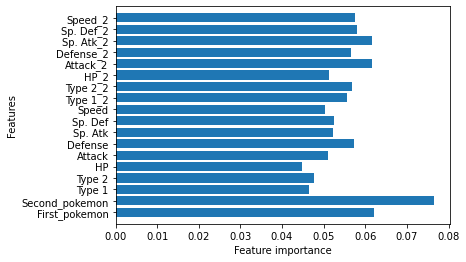

In [17]:
# grafico dell'importanza delle varie features nell'analisi
def plot_feature_importances(model):
    n_features = X_train.columns.values.size
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)

plot_feature_importances(tree)

In [18]:
# stampa dell'accuracy della previsione, il fatto che sia 1.000 sul training set è indice di attendibilità
# essendo quello l'insieme di addestramento
print("ACCURACY ON TRAINING SET: {:.3f}".format(tree.score(X_train, y_train)))
print("ACCURACY ON TEST SET: {:.3f}".format(tree.score(X_test, y_test)))

ACCURACY ON TRAINING SET: 1.000
ACCURACY ON TEST SET: 0.874
